# Понижение размерности: SVD и кластеризация

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_linnerud
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


## Датасет Linnerud

Набор данных `Linnerud` содержит физиологические измерения (вес, объём талии, пульс) для 20 испытуемых
и результаты их физических упражнений (подтягивания, скручивания, прыжки). 

In [2]:
linnerud = load_linnerud(as_frame=True)
exercises = linnerud.data
measures = linnerud.target
df = pd.concat({"exercise": exercises, "measure": measures}, axis=1)
df.head()

exercise               measure            
     Chins Situps  Jumps  Weight Waist Pulse
0      5.0  162.0   60.0   191.0  36.0  50.0
1      2.0  110.0   60.0   189.0  37.0  52.0
2     12.0  101.0  101.0   193.0  38.0  58.0
3     12.0  105.0   37.0   162.0  35.0  62.0
4     13.0  155.0   58.0   189.0  35.0  46.0

Рассматриваем матрицу физиологических показателей $X \in \mathbb{R}^{n 	\times p}$ (20 испытуемых и 3 признака).
После стандартизации каждая колонка имеет нулевое среднее и единичное стандартное отклонение, поэтому можно
сравнивать вклады $X_{ij}$ по единой шкале.


In [3]:
scaler = StandardScaler()
X = measures.values
X_scaled = scaler.fit_transform(X)
X_scaled[:5]

array([[ 0.51526412,  0.1922524 , -0.86798121],
       [ 0.43215701,  0.51267307, -0.5833972 ],
       [ 0.59837124,  0.83309374,  0.2703548 ],
       [-0.68978907, -0.12816827,  0.83952281],
       [ 0.43215701, -0.12816827, -1.43714921]])

## Вычисляем SVD

Напомним, что для матрицы $X$ сингулярное разложение имеет вид
$$
X = U \Sigma V^{T},
$$
где $\Sigma = \operatorname{diag}(\sigma_1, \ldots, \sigma_r)$, а столбцы $U$ и $V$ образуют ортонормированные
базисы в пространствах наблюдений и признаков.


In [4]:
U, s, Vt = np.linalg.svd(X_scaled, full_matrices=False)
pd.Series(s, name="σ").to_frame("singular value")


,singular value
0,6.487111
1,3.914659
2,1.610229


Сингулярные значения напрямую связаны с долей объяснённой дисперсии:
$$
\operatorname{f}_i = \frac{\sigma_i^2}{\sum_{j=1}^r \sigma_j^2}, \qquad
\operatorname{f}_{\le k} = \sum_{i=1}^k \operatorname{EVR}_i.
$$


In [5]:
explained = (s ** 2) / np.sum(s ** 2)
pd.Series(explained, index=[f"компонента {i+1}" for i in range(len(s))], name="доля дисперсии")


компонента 1    0.701377
компонента 2    0.255409
компонента 3    0.043214
Name: доля дисперсии, dtype: float64

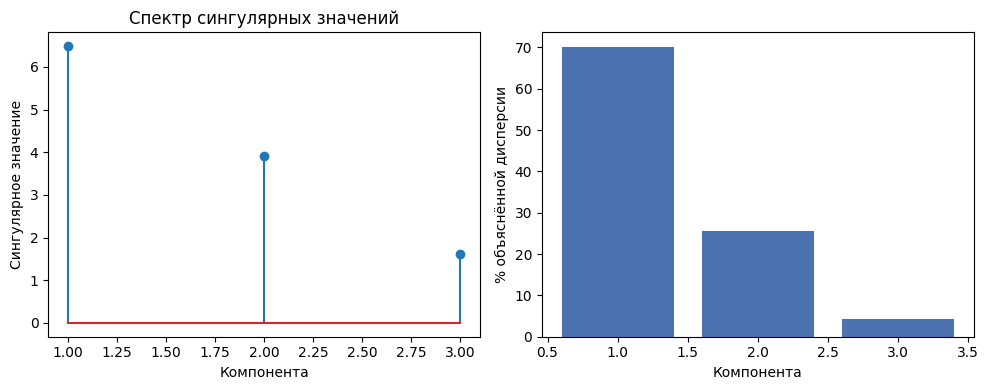

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].stem(range(1, len(s) + 1), s) #, use_line_collection=True)
ax[0].set_xlabel("Компонента")
ax[0].set_ylabel("Сингулярное значение")
ax[0].set_title("Спектр сингулярных значений")

ax[1].bar(range(1, len(s) + 1), explained * 100, color="#4c72b0")
ax[1].set_xlabel("Компонента")
ax[1].set_ylabel("% объяснённой дисперсии")
fig.tight_layout()


## Низкоранговая аппроксимация

Благодаря SVD легко построить матрицу ранга, которая минимизирует ошибку Фробениуса $\lVert X - X_k \rVert_F$. 

In [7]:
def low_rank_approx(X, k):
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    return (U[:, :k] * s[:k]) @ Vt[:k]

rank_2 = low_rank_approx(X_scaled, 2)
rel_error = np.linalg.norm(X_scaled - rank_2, ord="fro") / np.linalg.norm(X_scaled, ord="fro")
rel_error


np.float64(0.20787961474441796)

## Проекции и интерпретация

Первые сингулярные векторы задают «главные направления» вариации. Координаты проекции наблюдения $i$ в
пространство двух компонент вычисляются как $\mathbf{z}_i = (\sigma_1 u_{i1}, \sigma_2 u_{i2})$. Закодируем
цветом суммарную нагрузку (подтягивания + скручивания + прыжки).


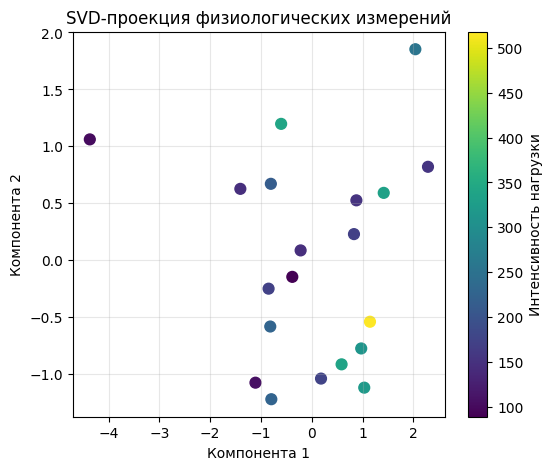

In [8]:
load_level = exercises.sum(axis=1)
proj = U[:, :2] * s[:2]

plt.figure(figsize=(6, 5))
sc = plt.scatter(proj[:, 0], proj[:, 1], c=load_level, cmap="viridis", s=60)
plt.xlabel("Компонента 1")
plt.ylabel("Компонента 2")
plt.title("SVD-проекция физиологических измерений")
plt.colorbar(sc, label="Интенсивность нагрузки")
plt.grid(True, alpha=0.3)


**Упражнение 1:**
Реализуйте функцию, которая вычисляет первые `k` сингулярные значения через собственные значения матрицы
$X^T X$ и сравните результат с `np.linalg.svd` на данных `measures`.


In [9]:
def top_singular_values_via_eig(X, k):
    """Возвращает k сингулярных значений, вычисленных через спектр X^T X."""
    XtX = X.T @ X
    eigvals = np.linalg.eigvalsh(XtX)
    sing_vals = np.sqrt(np.maximum(eigvals, 0))
    sing_vals_sorted = np.sort(sing_vals)[::-1]
    return sing_vals_sorted[:k]

sv_eig = top_singular_values_via_eig(X_scaled, k=3)
sv_svd = np.linalg.svd(X_scaled, full_matrices=False)[1]
print("Через eig:", sv_eig)
print("np.linalg.svd:", sv_svd)


Через eig: [6.48711099 3.91465898 1.61022857]
np.linalg.svd: [6.48711099 3.91465898 1.61022857]


**Упражнение 2:**
Добавьте к матрице физиологических показателей случайный шум (например, `np.random.normal`) и
примените SVD для фильтрации шума. 


In [10]:
np.random.seed(42)
noise = np.random.normal(scale=0.3, size=X_scaled.shape)
X_noisy = X_scaled + noise
rank_2_noisy = low_rank_approx(X_noisy, 2)
err_noisy = np.linalg.norm(X_noisy - X_scaled, ord='fro') / np.linalg.norm(X_scaled, ord='fro')
err_denoised = np.linalg.norm(rank_2_noisy - X_scaled, ord='fro') / np.linalg.norm(X_scaled, ord='fro')
print(f"Относительная ошибка между шумными и истинными: {err_noisy:.3f}")
print(f"После ранга-2 (SVD) ошибка: {err_denoised:.3f}")


Относительная ошибка между шумными и истинными: 0.274
После ранга-2 (SVD) ошибка: 0.311


**Упражнение 3:**
Постройте PCA при помощи `sklearn.decomposition.PCA` и сравните доли объяснённой дисперсии и проекции
с тем, что мы получили вручную через SVD.


Доли дисперсии PCA: [0.70137682 0.25540925 0.04321393]
Сингулярные значения PCA: [6.48711099 3.91465898 1.61022857]
Сингулярные значения SVD: [6.48711099 3.91465898 1.61022857]


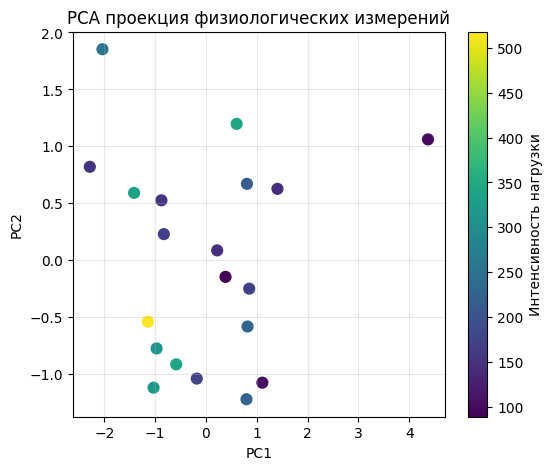

In [11]:
pca = PCA(n_components=3, random_state=42)
pca.fit(X_scaled)
print("Доли дисперсии PCA:", pca.explained_variance_ratio_)
print("Сингулярные значения PCA:", pca.singular_values_)
print("Сингулярные значения SVD:", s)
proj_pca = pca.transform(X_scaled)[:, :2]
plt.figure(figsize=(6,5))
plt.scatter(proj_pca[:,0], proj_pca[:,1], c=load_level, cmap='viridis', s=60)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA проекция физиологических измерений')
plt.colorbar(label='Интенсивность нагрузки')
plt.grid(True, alpha=0.3)


# Кластеризация

Теперь переходим к анализу химических данных: посмотрим, как знания о структуре признаков помогают выбирать
алгоритм и метрики кластеризации.


Кластеризация помогает обнаруживать группы наблюдений без заранее известных меток. Мы поработаем с
"химическим датасетом" `Wine` из `sklearn.datasets`.

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage

## Датасет Wine

Набор содержит результаты химического анализа 13 параметров вин из трёх регионов Италии. 

In [13]:
wine = load_wine(as_frame=True)
X = wine.data
y = wine.target
X.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


Перед кластеризацией пронормируем признаки: мы работаем с метрическим методом.


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Визуализация через PCA

Проецируем данные в две компоненты PCA, а подписи к осям отражают процент информации, объяснённой компонентой.

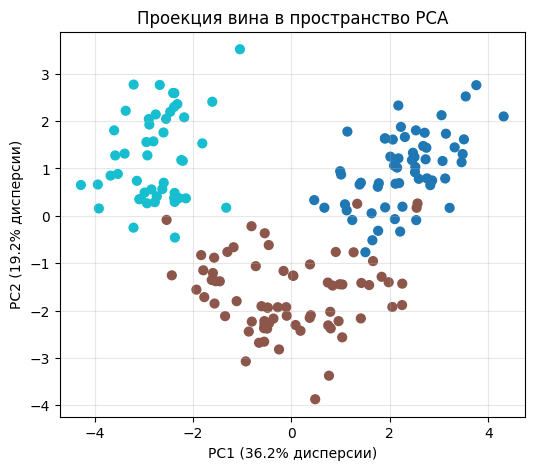

In [15]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
proj_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
proj_df["class"] = y

plt.figure(figsize=(6,5))
scatter = plt.scatter(proj_df["PC1"], proj_df["PC2"], c=proj_df["class"], cmap="tab10", s=40)
plt.xlabel("PC1 ({:.1f}% дисперсии)".format(pca.explained_variance_ratio_[0]*100))
plt.ylabel("PC2 ({:.1f}% дисперсии)".format(pca.explained_variance_ratio_[1]*100))
plt.title("Проекция вина в пространство PCA")
plt.grid(True, alpha=0.3)


**Упражнение (со звездочкой):**
Проведите факторный анализ при помощи `sklearn.decomposition.FactorAnalysis`. Сравните факторные нагрузки
с PCA-компонентами: визуализируйте матрицу коэффициентов, предложите интерпретацию факторов.

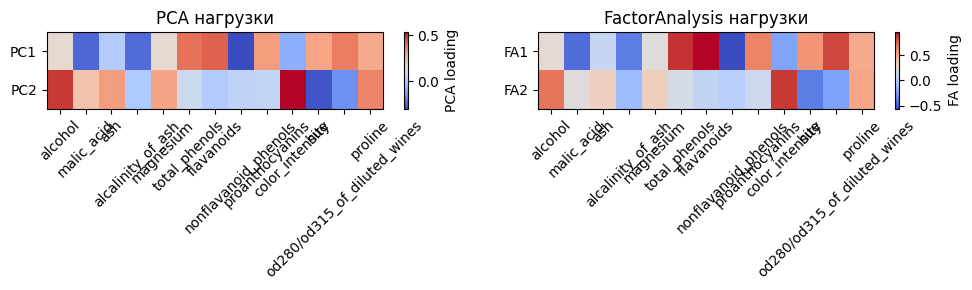

In [16]:
from sklearn.decomposition import FactorAnalysis
fa = FactorAnalysis(n_components=2, random_state=42)
fa_components = fa.fit_transform(X_scaled)
fa_loadings = fa.components_
feature_names = wine.feature_names if 'wine' in globals() else measures.columns
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.imshow(pca.components_, cmap='coolwarm', aspect='auto')
plt.colorbar(label='PCA loading')
plt.xticks(range(len(feature_names)), feature_names, rotation=45)
plt.yticks(range(pca.components_.shape[0]), [f'PC{i+1}' for i in range(pca.components_.shape[0])])
plt.title('PCA нагрузки')
plt.subplot(1,2,2)
plt.imshow(fa_loadings, cmap='coolwarm', aspect='auto')
plt.colorbar(label='FA loading')
plt.xticks(range(len(feature_names)), feature_names, rotation=45)
plt.yticks(range(fa_loadings.shape[0]), [f'FA{i+1}' for i in range(fa_loadings.shape[0])])
plt.title('FactorAnalysis нагрузки')
plt.tight_layout()


## KMeans

KMeans минимизирует квадратичные расстояния до центроидов:
$$
L = \sum_{i=1}^n \lVert \mathbf{x}_i - \mu_{c_i} \rVert^2,
$$
где $c_i$ — индекс полученного кластера. Используем $k=3$ (по числу регионов) и инициализацию k-means++, чтобы избежать локальных минимумов.

In [17]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans.fit(X_scaled)
km_labels = kmeans.labels_
kmeans.inertia_


1277.928488844642

Оценим качество по силуэту и по меткам (ARI), которые нам известны для диагностики.


In [18]:
silhouette = silhouette_score(X_scaled, km_labels)
ari = adjusted_rand_score(y, km_labels)
silhouette, ari


(0.2848589191898987, 0.8974949815093207)

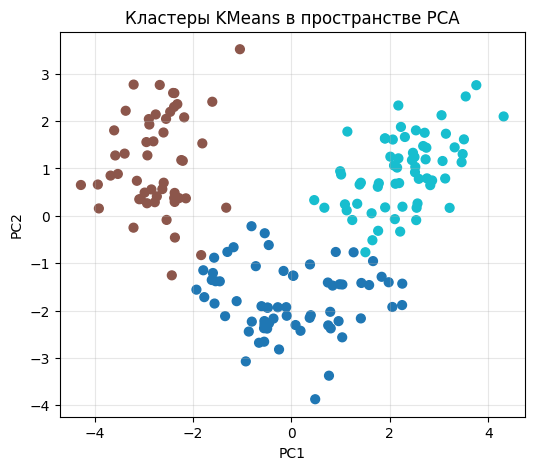

In [19]:
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=km_labels, cmap="tab10", s=40)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Кластеры KMeans в пространстве PCA")
plt.grid(True, alpha=0.3)


### Локтевой график и силуэт для выбора k

Инерция модели равна тому же функционалу $L$, поэтому «локоть» показывает, где добавление кластера перестаёт заметно уменьшать результат. Силуэт каждой точки
$$
 s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}},
$$
где $a(i)$ — среднее внутрикластерное расстояние, а $b(i)$ — минимальное из средних расстояний до соседних
кластеров, помогает выбрать $k$ с наилучшей разделимостью.


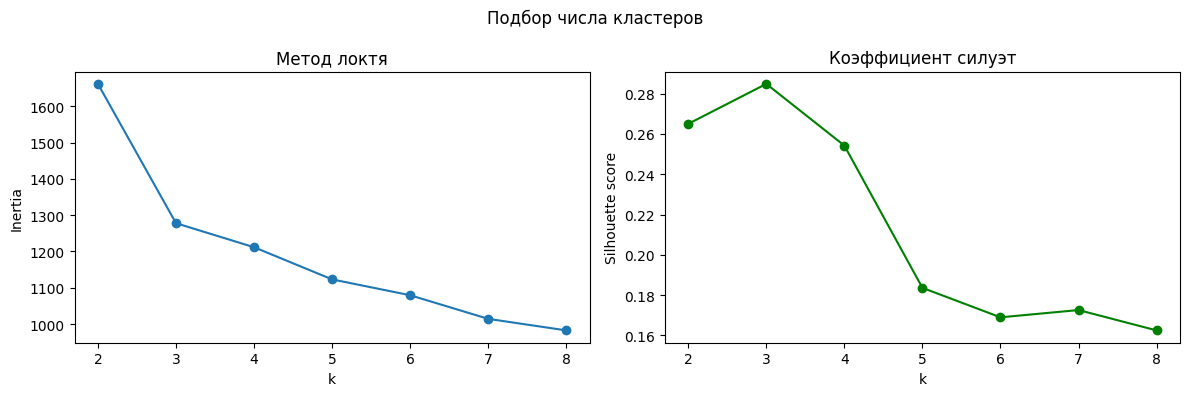

In [20]:
inertias = []
silhouettes = []
k_range = range(2, 9)
for k in k_range:
    model = KMeans(n_clusters=k, init='k-means++', random_state=42)
    model.fit(X_scaled)
    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(X_scaled, model.labels_))

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].plot(list(k_range), inertias, marker="o")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")
ax[0].set_title("Метод локтя")

ax[1].plot(list(k_range), silhouettes, marker="o", color="green")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Silhouette score")
ax[1].set_title("Коэффициент силуэт")
fig.suptitle("Подбор числа кластеров")
fig.tight_layout()


## Иерархическая кластеризация

Метод Варда объединяет кластеры, минимизируя увеличение внутрикластерной дисперсии. Для кластеров $C_i$ и
$C_j$ расстояние имеет вид
$$d_{\text{Ward}}(C_i, C_j) = \frac{|C_i| \cdot |C_j|}{|C_i| + |C_j|}\lVert {\mu}_i - {\mu}_j \rVert_2^2,$$
где ${\mu}_i$ — центроид кластера. Это делает дендрограмму особенно чувствительной к компактным
группам в числовых данных.


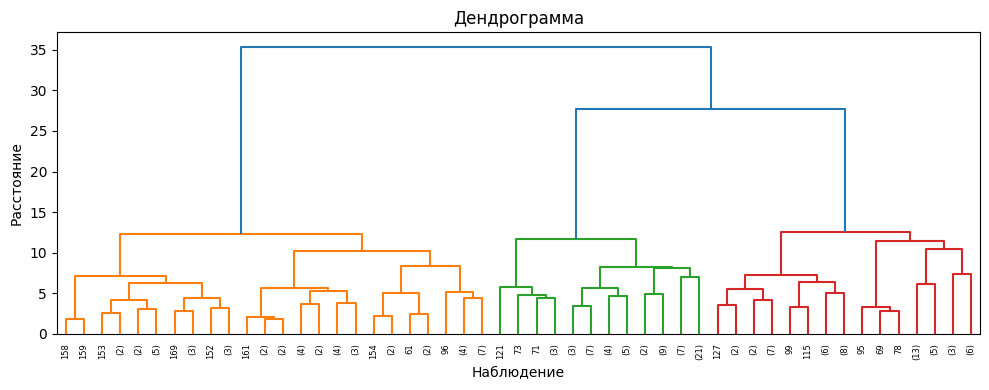

In [21]:
linkage_matrix = linkage(X_scaled, method="ward") # расстояние Варда
plt.figure(figsize=(10, 4))
dendrogram(linkage_matrix, truncate_mode="level", p=5)
plt.title("Дендрограмма")
plt.xlabel("Наблюдение")
plt.ylabel("Расстояние")
plt.tight_layout()


In [22]:
agg = AgglomerativeClustering(n_clusters=3, linkage="ward")
agg_labels = agg.fit_predict(X_scaled)
adjusted_rand_score(y, agg_labels)


0.7899332213582837

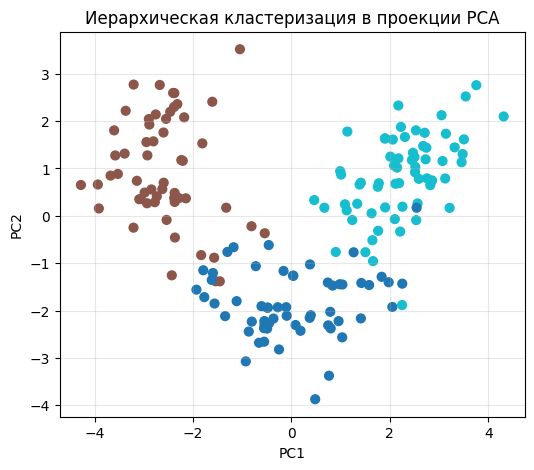

In [23]:
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=agg_labels, cmap="tab10", s=40)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Иерархическая кластеризация в проекции PCA")
plt.grid(True, alpha=0.3)


**Упражнение 4**:
Настройте масштабирование и `KMeans` с поиском оптимального `k` по максимуму силуэта. Используйте pipeline,
чтобы комбинировать `StandardScaler` и `KMeans`.


In [24]:
from sklearn.pipeline import Pipeline
best = None
results = []
for k in range(2, 9):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=k, init='k-means++', random_state=42)),
    ])
    labels = pipe.fit_predict(X)
    sil = silhouette_score(pipe['scaler'].transform(X), labels)
    results.append((k, sil))
    if best is None or sil > best[1]:
        best = (k, sil, pipe)
    print(f"k={k}, silhouette={sil:.3f}")
print(f"Лучший k по силуэту: {best[0]}, score={best[1]:.3f}")


k=2, silhouette=0.265
k=3, silhouette=0.285
k=4, silhouette=0.254
k=5, silhouette=0.184
k=6, silhouette=0.169
k=7, silhouette=0.173
k=8, silhouette=0.163
Лучший k по силуэту: 3, score=0.285


**Упражнение 5:**
Реализуйте кластеризацию методом DBSCAN или GaussianMixture из состава sklearn и сравните метрики (silhouette, ARI)
с результатами KMeans/AgglomerativeClustering.


In [25]:
from sklearn.mixture import GaussianMixture
X_std = scaler.fit_transform(X)
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm_labels = gmm.fit_predict(X_std)
gmm_sil = silhouette_score(X_std, gmm_labels)
gmm_ari = adjusted_rand_score(y, gmm_labels)
print(f"GMM silhouette={gmm_sil:.3f}, ARI={gmm_ari:.3f}")
print(f"KMeans silhouette={silhouette:.3f}, ARI={ari:.3f}")


GMM silhouette=0.285, ARI=0.897
KMeans silhouette=0.285, ARI=0.897


**Упражнение (со звездочкой):**
Скачайте датасет `Ionosphere` (радарные измерения верхних слоёв атмосферы) через
`sklearn.datasets.fetch_openml("ionosphere", version=1, as_frame=True)`. Стандартизируйте признаки, постройте 2D-проекции
(SVD/PCA) и сравните результаты `KMeans`, `AgglomerativeClustering` и выбранного вами алгоритма плотностной
кластеризации (DBSCAN или GaussianMixture). Постройте силуэт, ARI и дендрограммы.

Не удалось загрузить ionosphere, используем синтетические данные: ionosphere dataset is empty after cleaning
KMeans: silhouette=0.148, ARI=0.010
Agglomerative: silhouette=0.105, ARI=-0.003
GMM: silhouette=0.148, ARI=0.001


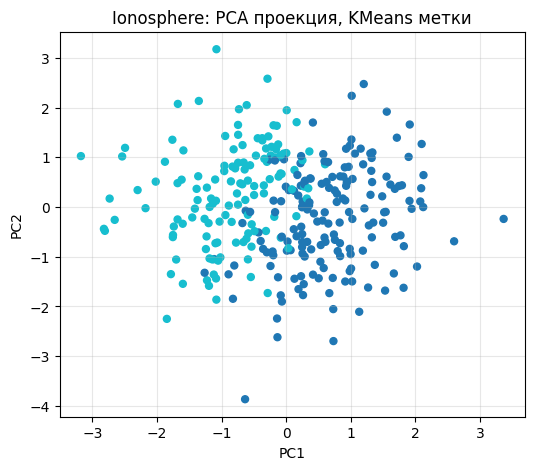

In [26]:
from sklearn.datasets import fetch_openml
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

try:
    ion = fetch_openml("ionosphere", version=1, as_frame=True)
    X_ion_df = ion.data.apply(pd.to_numeric, errors="coerce")
    target_mapped = ion.target.map({"good": 1, "bad": 0})
    mask = target_mapped.notna()
    X_ion_df = X_ion_df.loc[mask]
    target_mapped = target_mapped.loc[mask]
    finite_mask = X_ion_df.notna().all(axis=1)
    X_ion_df = X_ion_df.loc[finite_mask]
    target_mapped = target_mapped.loc[finite_mask]
    X_ion = X_ion_df.to_numpy(dtype=float)
    y_ion = target_mapped.to_numpy(dtype=int)
    if X_ion.shape[0] == 0:
        raise ValueError("ionosphere dataset is empty after cleaning")
    print("Загрузили ionosphere с OpenML")
except Exception as e:
    rng = np.random.default_rng(42)
    X_ion = rng.normal(size=(300, 5))
    y_ion = rng.integers(0, 2, size=300)
    print("Не удалось загрузить ionosphere, используем синтетические данные:", e)

X_ion_std = StandardScaler().fit_transform(X_ion)

pca_ion = PCA(n_components=2, random_state=42)
X_ion_pca = pca_ion.fit_transform(X_ion_std)

kmeans_ion = KMeans(n_clusters=2, random_state=42).fit(X_ion_std)
agg_ion = AgglomerativeClustering(n_clusters=2, linkage="ward").fit(X_ion_std)
gmm_ion = GaussianMixture(n_components=2, random_state=42).fit(X_ion_std)

labels = {
    "KMeans": kmeans_ion.labels_,
    "Agglomerative": agg_ion.labels_,
    "GMM": gmm_ion.predict(X_ion_std),
}

for name, lab in labels.items():
    sil = silhouette_score(X_ion_std, lab)
    ari = adjusted_rand_score(y_ion, lab)
    print(f"{name}: silhouette={sil:.3f}, ARI={ari:.3f}")

plt.figure(figsize=(6, 5))
plt.scatter(X_ion_pca[:, 0], X_ion_pca[:, 1], c=kmeans_ion.labels_, cmap="tab10", s=25)
plt.title("Ionosphere: PCA проекция, KMeans метки")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
